Задача:  
Построить две модели бинарной классификации текстов(комментарии на английском языке разделить на позитивные и негативные).  

Исходные данные:  
3 датасета — с комментариями, размеченные на позитивные — 1 и негативные — 0.
Список датасетов: **amazon_cells_labelled.txt, imdb_labelled.txt, yelp_labelled.txt**.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import re

In [2]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

In [3]:
#import nltk
#nltk.download('popular')

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = 4000

## 1. Проведем подготовку датасетов к классификации.

### 1.1. Загрузим данные, проведем первичный анализ и объединим датасеты в одну выборку.

In [4]:
print('dataset #1\n')
df_1 = pd.read_csv('datasets/amazon_cells_labelled.txt', names=['text', 'target'], sep='\t')
display(df_1.info(), df_1.shape, df_1.head())

print('dataset #2\n')
df_2 = pd.read_csv('datasets/imdb_labelled.txt', names=['text', 'target'], sep='\t')
display(df_2.info(), df_2.shape, df_2.head())

print('dataset #3\n')
df_3 = pd.read_csv('datasets/yelp_labelled.txt', names=['text', 'target'], sep='\t')
display(df_3.info(), df_3.shape, df_3.head())


dataset #1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   target  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


None

(1000, 2)

,text,target
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


dataset #2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    748 non-null    object
 1   target  748 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB


None

(748, 2)

,text,target
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1


dataset #3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   target  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


None

(1000, 2)

,text,target
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,The selection on the menu was great and so were the prices.,1


Датасеты загружены, пропусков в данных нет, типы данных впорядке. Проверим баланс классов целевого признака **target**

In [5]:
for name_df in [df_1, df_2, df_3]:
    print(name_df['target'].value_counts())

1    500
0    500
Name: target, dtype: int64
1    386
0    362
Name: target, dtype: int64
1    500
0    500
Name: target, dtype: int64


Классы сбалансированы, в каждом датасете примерно поровну положительных и отрицательных классов. Объединим датасеты в одну выборку

In [6]:
data = pd.concat([df_1, df_2, df_3]).reset_index(drop=True)
display(data.tail(3))
print(data.shape)
#возможно стоило бы перемешать данные, т.к. они поступили из разных источников.
#Но с другой стороны мы потом будем делить их на треин и тест случайным образом, поэтому оставил все как есть.

,text,target
2745,Overall I was not impressed and would not go back.,0
2746,"The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time.",0
2747,"Then, as if I hadn't wasted enough of my life there, they poured salt in the wound by drawing out the time it took to bring the check.",0


(2748, 2)


### 1.2. Проведем нормализацию текста (удаление знаков препинания, удаление стоп слов, приведение слов к начальной форме(стемминг)).

На хабре нашел некоторые рекомендации, пару из них применю:  
    1. Переведём тексты в стандартный для Python формат: кодировку Unicode (U) (на всякий случай).  
    2. В дальнейшем, чтобы снизить требования к вычислительным ресурсам можно игнорировать регистр слов.

In [7]:
data.tail(3)

,text,target
2745,Overall I was not impressed and would not go back.,0
2746,"The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time.",0
2747,"Then, as if I hadn't wasted enough of my life there, they poured salt in the wound by drawing out the time it took to bring the check.",0


In [8]:
data['text'] = data['text'].values.astype('U')

In [9]:
data['text'] = data['text'].str.lower()

In [10]:
data.tail(3)

,text,target
2745,overall i was not impressed and would not go back.,0
2746,"the whole experience was underwhelming, and i think we'll just go to ninja sushi next time.",0
2747,"then, as if i hadn't wasted enough of my life there, they poured salt in the wound by drawing out the time it took to bring the check.",0


### 1.2.1. Удалим знаки препинания

В процессе обработки было замечено, что отзывы в основном состоят из одного предложения. Поэтому, если принять данное предположение: один отзыв - это одно предложение, то можно сразу же очистить данные от знаков препинания, используя регулярные выражения. 

In [11]:
data.head(10)

,text,target
0,so there is no way for me to plug it in here in the us unless i go by a converter.,0
1,"good case, excellent value.",1
2,great for the jawbone.,1
3,tied to charger for conversations lasting more than 45 minutes.major problems!!,0
4,the mic is great.,1
5,i have to jiggle the plug to get it to line up right to get decent volume.,0
6,"if you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.",0
7,if you are razr owner...you must have this!,1
8,"needless to say, i wasted my money.",0
9,what a waste of money and time!.,0


In [12]:
pattern = r'[^a-z]'#шаблон, верхний регистр мы убрали, цифры также не рассматриваем
replacement = ' '#будем заменять на пробелы

data['text'] = data['text'].apply(lambda x: re.sub(pattern, replacement, x))

In [13]:
data.head(10)

,text,target
0,so there is no way for me to plug it in here in the us unless i go by a converter,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more than minutes major problems,0
4,the mic is great,1
5,i have to jiggle the plug to get it to line up right to get decent volume,0
6,if you have several dozen or several hundred contacts then imagine the fun of sending each of them one by one,0
7,if you are razr owner you must have this,1
8,needless to say i wasted my money,0
9,what a waste of money and time,0


Удаление знаков препинания и цыфр прошло успешно. Возможно цыфры и играют роль, но это требует доп.исследования.

### 1.2.2. Проведем токенизацию и приведем слова к начальной форме (стемминг)

In [14]:
stemmer = PorterStemmer()

In [15]:
data.head(4)

,text,target
0,so there is no way for me to plug it in here in the us unless i go by a converter,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more than minutes major problems,0


In [16]:
#Новую колонку сделал для записи, на тот случай, если понадобиться исходный текст отзыва. 
#Например, захотим провести лемматизацию и сравнить два подхода.
#word_tokenize - разбивает текст на токены-слова
data['text_stemmer'] = data['text'].apply(lambda x: [stemmer.stem(word) for word in word_tokenize(x)])

In [17]:
data.head(4)

,text,target,text_stemmer
0,so there is no way for me to plug it in here in the us unless i go by a converter,0,"[so, there, is, no, way, for, me, to, plug, it, in, here, in, the, us, unless, i, go, by, a, convert]"
1,good case excellent value,1,"[good, case, excel, valu]"
2,great for the jawbone,1,"[great, for, the, jawbon]"
3,tied to charger for conversations lasting more than minutes major problems,0,"[tie, to, charger, for, convers, last, more, than, minut, major, problem]"


### 1.2.3. Удалим стоп слова из токенизированных предложений.

In [18]:
stop_wd = set(stopwords.words("english"))

In [19]:
data.head(4)

,text,target,text_stemmer
0,so there is no way for me to plug it in here in the us unless i go by a converter,0,"[so, there, is, no, way, for, me, to, plug, it, in, here, in, the, us, unless, i, go, by, a, convert]"
1,good case excellent value,1,"[good, case, excel, valu]"
2,great for the jawbone,1,"[great, for, the, jawbon]"
3,tied to charger for conversations lasting more than minutes major problems,0,"[tie, to, charger, for, convers, last, more, than, minut, major, problem]"


In [20]:
data['text_stemmer'] = data['text_stemmer'].apply(lambda x: [word for word in x if not word in stop_wd])

In [21]:
data.head(4)

,text,target,text_stemmer
0,so there is no way for me to plug it in here in the us unless i go by a converter,0,"[way, plug, us, unless, go, convert]"
1,good case excellent value,1,"[good, case, excel, valu]"
2,great for the jawbone,1,"[great, jawbon]"
3,tied to charger for conversations lasting more than minutes major problems,0,"[tie, charger, convers, last, minut, major, problem]"


In [22]:
#объединим слова заново в текст
data['text_stemmer'] = data['text_stemmer'].apply(lambda x: " ".join(x))
data.head(4)

,text,target,text_stemmer
0,so there is no way for me to plug it in here in the us unless i go by a converter,0,way plug us unless go convert
1,good case excellent value,1,good case excel valu
2,great for the jawbone,1,great jawbon
3,tied to charger for conversations lasting more than minutes major problems,0,tie charger convers last minut major problem


## 1.3. Разделим выборку на **train** и **test** 

В начале разделим датасет на целовой признак и текст

In [23]:
text = data['text_stemmer']
target = data['target']

Теперь проведем разделение выборок на трейн и тест в соотношении **3:1**

In [24]:
text_train, text_test, target_train, target_test = train_test_split(text, target, test_size=0.25, random_state=100)

In [25]:
print(len(text_train), len(text_test), len(target_train), len(target_test))

2061 687 2061 687


In [26]:
text_train

405     especi love long batteri life                                                                            
2368    chicken pho tast veri bland                                                                              
1614    achil philippa beauti sing duet giovanni perfectli describ situat movi appreci subtl layer thi excel film
965     make call certain place                                                                                  
931     thi pair headphon worst ever sound wise                                                                  
                         ...                                                                                     
350     jerk phone                                                                                               
1930    dress treat rude                                                                                         
79      purchas thi within day wa longer work                                           

## 1.4. Займемся извлечением признаков.

Конвертируем текст в векторы.

In [27]:
tfidf_text = TfidfVectorizer()
tfidf_text.fit(text_train)

print('Количество уникальных слов:', len(tfidf_text.get_feature_names()))

Количество уникальных слов: 3369


In [28]:
values = tfidf_text.transform(text_train)

In [29]:
print(type(values))

<class 'scipy.sparse.csr.csr_matrix'>


count    14167.000000
mean     0.344804    
std      0.162416    
min      0.015286    
25%      0.244777    
50%      0.329455    
75%      0.432214    
max      1.000000    
dtype: float64


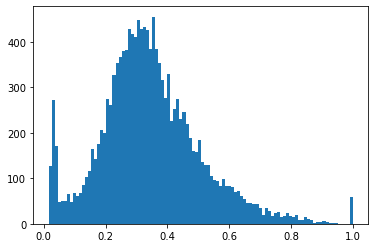

In [30]:
print(pd.Series(values.data).describe())
plt.hist(values.data, bins = 100)
plt.show()

In [31]:
#проверка
display(pd.DataFrame(values.toarray(), columns = tfidf_text.get_feature_names()).head())
display(text_train.head())

aailiyah  abhor  abil  abl  abound  abov  absolut  absolutel  absolutley  \
0  0.0       0.0    0.0   0.0  0.0     0.0   0.0      0.0        0.0          
1  0.0       0.0    0.0   0.0  0.0     0.0   0.0      0.0        0.0          
2  0.0       0.0    0.0   0.0  0.0     0.0   0.0      0.0        0.0          
3  0.0       0.0    0.0   0.0  0.0     0.0   0.0      0.0        0.0          
4  0.0       0.0    0.0   0.0  0.0     0.0   0.0      0.0        0.0          

   abstrus  abysm   ac  academi  accept  access  accessori  accessoryon  \
0  0.0      0.0    0.0  0.0      0.0     0.0     0.0        0.0           
1  0.0      0.0    0.0  0.0      0.0     0.0     0.0        0.0           
2  0.0      0.0    0.0  0.0      0.0     0.0     0.0        0.0           
3  0.0      0.0    0.0  0.0      0.0     0.0     0.0        0.0           
4  0.0      0.0    0.0  0.0      0.0     0.0     0.0        0.0           

   accid  acclaim  accolad  accomod  accompani  accord  account  accur  accus  \
0  0.0    0.0      0.0      0.0      0.0        0.0     0.0      0.0    0.0     
1  0.0    0.0      0.0      0.0      0.0        0.0     0.0      0.0    0.0     
2  0.0    0.0      0.0      0.0      0.0        0.0     0.0      0.0    0.0     
3  0.0    0.0      0.0      0.0      0.0        0.0     0.0      0.0    0.0     
4  0.0    0.0      0.0      0.0      0.0        0.0     0.0      0.0    0.0     

   ach  achiev     achil  ackerman  acknowledg  across  act  action  activ  \
0  0.0  0.0     0.000000  0.0       0.0         0.0     0.0  0.0     0.0     
1  0.0  0.0     0.000000  0.0       0.0         0.0     0.0  0.0     0.0     
2  0.0  0.0     0.303532  0.0       0.0         0.0     0.0  0.0     0.0     
3  0.0  0.0     0.000000  0.0       0.0         0.0     0.0  0.0     0.0     
4  0.0  0.0     0.000000  0.0       0.0         0.0     0.0  0.0     0.0     

   activesync  actor  actress  actual   ad  adapt  add  addit  address  admin  \
0  0.0         0.0    0.0      0.0     0.0  0.0    0.0  0.0    0.0      0.0     
1  0.0         0.0    0.0      0.0     0.0  0.0    0.0  0.0    0.0      0.0     
2  0.0         0.0    0.0      0.0     0.0  0.0    0.0  0.0    0.0      0.0     
3  0.0         0.0    0.0      0.0     0.0  0.0    0.0  0.0    0.0      0.0     
4  0.0         0.0    0.0      0.0     0.0  0.0    0.0  0.0    0.0      0.0     

   admir  admit  ador  adrift  adventur  advertis  advis  aerial  aesthet  \
0  0.0    0.0    0.0   0.0     0.0       0.0       0.0    0.0     0.0       
1  0.0    0.0    0.0   0.0     0.0       0.0       0.0    0.0     0.0       
2  0.0    0.0    0.0   0.0     0.0       0.0       0.0    0.0     0.0       
3  0.0    0.0    0.0   0.0     0.0       0.0       0.0    0.0     0.0       
4  0.0    0.0    0.0   0.0     0.0       0.0       0.0    0.0     0.0       

   affect  afford  afraid  afternoon  age  aggrav  ago  agre  aimless  air  \
0  0.0     0.0     0.0     0.0        0.0  0.0     0.0  0.0   0.0      0.0   
1  0.0     0.0     0.0     0.0        0.0  0.0     0.0  0.0   0.0      0.0   
2  0.0     0.0     0.0     0.0        0.0  0.0     0.0  0.0   0.0      0.0   
3  0.0     0.0     0.0     0.0        0.0  0.0     0.0  0.0   0.0      0.0   
4  0.0     0.0     0.0     0.0        0.0  0.0     0.0  0.0   0.0      0.0   

   airlin  airport  akasha  akin  alarm  alert  alexand  alik  allergi  \
0  0.0     0.0      0.0     0.0   0.0    0.0    0.0      0.0   0.0       
1  0.0     0.0      0.0     0.0   0.0    0.0    0.0      0.0   0.0       
2  0.0     0.0      0.0     0.0   0.0    0.0    0.0      0.0   0.0       
3  0.0     0.0      0.0     0.0   0.0    0.0    0.0      0.0   0.0       
4  0.0     0.0      0.0     0.0   0.0    0.0    0.0      0.0   0.0       

   allison  allow  almost  alon  along  alongsid  alot  alreadi  also  \
0  0.0      0.0    0.0     0.0   0.0    0.0       0.0   0.0      0.0    
1  0.0      0.0    0.0     0.0   0.0    0.0       0.0   0.0      0.0    
2  0.0      0.0    0.0     0.0   0.0  

405     especi love long batteri life                                                                            
2368    chicken pho tast veri bland                                                                              
1614    achil philippa beauti sing duet giovanni perfectli describ situat movi appreci subtl layer thi excel film
965     make call certain place                                                                                  
931     thi pair headphon worst ever sound wise                                                                  
Name: text_stemmer, dtype: object

Сделаем отсечение высокочастотных и низкочастотных слов. Сделаем это, указав соответствующие пороги. Мы уже удаляли высокочастотные слова, посредством удаления стоп-слов и поидее таких недолжно быть. Проверим.

In [32]:
tfidf_text_cut = TfidfVectorizer(max_df = 0.9)
tfidf_text_cut.fit(text_train)

print('Количество уникальных слов:', len(tfidf_text_cut.get_feature_names()))

Количество уникальных слов: 3369


Теперь рассмотрим низкочастотные слова, исключим слова которые встречаются менее 2 раз. (Сначала брал 5, потом оказалось, что на данной выборке при 2 скор у модели лучше, скорее всего это связано с тем, что у нас слишком короткие тексты в отзывах)

In [33]:
tfidf_text_cut = TfidfVectorizer(max_df = 0.9, min_df = 2)
tfidf_text_cut.fit(text_train)

print('Количество уникальных слов в словаре:', len(tfidf_text_cut.get_feature_names()))
#print(len(tfidf_text_cut.vocabulary_))

Количество уникальных слов в словаре: 1518


**Подготовим признаки для классификации**

In [34]:
features_train  = tfidf_text_cut.transform(text_train)
features_test  = tfidf_text_cut.transform(text_test)

Параметры для **TfidfVectorizer** определены. Можно переходить к обучению моделей.

## 2. Построение модлей.

Согласно заданию будем рассматривать только две модели: **RandomForest** и **KNN**  

**Выбор метрики.**  
Так как у нас два целевых класса сбалансированы. И в задании не сказано какому классу отдается предпочтение с точки зрения "бизнеса", то в качестве метрики будем использовать **accuracy**

### 2.1. KNeighbors

In [35]:
knn_clf = KNeighborsClassifier()

In [36]:
#Будем варьировать гиперпараметр - количество соседей
params = {'n_neighbors': range(1,152,5)}

#scoring по умолчанию accurancy
gs_knn = GridSearchCV(estimator = knn_clf, 
                      param_grid = params, 
                      cv = 5, 
                      scoring = 'accuracy', 
                      n_jobs=-1
)

In [37]:
%%time
fitted_model_knn = gs_knn.fit(features_train, target_train)

Wall time: 12.3 s


In [38]:
print('Лучшие гиперпараметры: ', fitted_model_knn.best_params_)
print('Лучший score на тренировочной выборке: ', fitted_model_knn.best_score_)

Лучшие гиперпараметры:  {'n_neighbors': 26}
Лучший score на тренировочной выборке:  0.7603152401325842


In [39]:
#Проверка на тесте
predicted_knn = fitted_model_knn.best_estimator_.predict(features_test)

print('Матрица ошибок\n', confusion_matrix(target_test, predicted_knn))
print('\naccuracy на тестовой выборке: ', accuracy_score(target_test, predicted_knn))

Матрица ошибок
 [[265  81]
 [ 73 268]]

accuracy на тестовой выборке:  0.7758369723435226


### 2.2. RandomForest

In [40]:
rf_clf = RandomForestClassifier(n_jobs=-1, random_state = 100)

In [41]:
#Будем варьировать гиперпараметры - количество деревьев, максимальная глубина дерева.
params = {'n_estimators': range(50,201,50), 'max_depth': range(30,121,10)}


gs_rf = GridSearchCV(estimator = rf_clf, 
                      param_grid = params, 
                      cv = 5, 
                      scoring = 'accuracy', 
                      n_jobs=-1
)

In [42]:
%%time
fitted_model_rf = gs_rf.fit(features_train, target_train)

Wall time: 3min 11s


In [43]:
print('Лучшие гиперпараметры: ', fitted_model_rf.best_params_)
print('Лучший score на тренировочной выборке: ', fitted_model_rf.best_score_)

Лучшие гиперпараметры:  {'max_depth': 120, 'n_estimators': 200}
Лучший score на тренировочной выборке:  0.7816685864735889


In [44]:
#Проверка на тесте
predicted_rf = fitted_model_rf.best_estimator_.predict(features_test)

print('Матрица ошибок\n', confusion_matrix(target_test, predicted_rf))
print('\naccuracy на тестовой выборке: ', accuracy_score(target_test, predicted_rf))

Матрица ошибок
 [[289  57]
 [ 99 242]]

accuracy на тестовой выборке:  0.7729257641921398


# Вывод  

    Обе модели классификации дают приблизительно одинаковые результаты: ~78% объектов класифицируем правильно (случайный лес немного лучше). Это лучше случайной и константной модели (они будут давать приблизительно 50%). Построенные нами модели можно считать адекватными. Дальнейшее улучшение метрики можно попытаться добиться за счет рассмотрения n-грамм в качестве признаков. Или же провести лемматизацию вместо стемминга.  
    
    Сходство в конечных метриках, которое мы получили, иллюстрирует математическое утверждение, что метод случайного леса схож с методом ближайших соседей. Т.к. случайные леса, осуществляют предсказания для объектов на основе меток похожих объектов из обучения. При этом схожесть объектов тем выше, чем чаще эти объекты оказываются в одном и том же листе   дерева.  
    
    Какую модель выбрать будет зависеть от бизнес-задачи если нужно, чтобы модель быстро обучалась, то лучше использовать knn, если важны сотые процента у метрики, то возможно лучше отдать предпочтение случайному лесу.  


### Дополнительно.

Проделаем все тоже самое из пунктов **1.4** и **2**, с использованием ***Pipeline***

In [45]:
#нужно определить, т.к. TfidfVectorizer.fit() делаем только на обучающей выборке
class vectorizator:
    def __init__(self, model):
        self.model = model
    
    def fit(self, text, y=None):
        return self.model
    
    def transform(self, text, y=None):
        return self.model.transform(text)

In [46]:
vect = vectorizator(TfidfVectorizer(max_df = 0.9, min_df = 2).fit(text_train))

#### knn

In [47]:
pipe_knn = Pipeline([('tf_idf', vect), 
                     ('knn', knn_clf)])

In [48]:
params_pipe_knn = {'knn__n_neighbors': list(range(1,152,5))}

gs_pipe_knn = GridSearchCV(estimator = pipe_knn, 
                      param_grid = params_pipe_knn, 
                      cv=5, 
                      n_jobs=-1 
)

In [49]:
#будем передовать в пайплайн не векторизированный текст
text_train.head(2)

405     especi love long batteri life
2368    chicken pho tast veri bland  
Name: text_stemmer, dtype: object

In [50]:
%%time
fitted_pipe_knn = gs_pipe_knn.fit(text_train, target_train)

Wall time: 17.8 s


In [51]:
#fitted_pipe_knn.best_params_
print('Лучшие гиперпараметры: ', fitted_pipe_knn.best_params_)
print('Лучший score на тренировочной выборке: ', fitted_pipe_knn.best_score_)

Лучшие гиперпараметры:  {'knn__n_neighbors': 26}
Лучший score на тренировочной выборке:  0.7603152401325842


In [52]:
predicted = fitted_pipe_knn.best_estimator_.predict(text_test)

print('Матрица ошибок\n', confusion_matrix(target_test, predicted))
print('\naccuracy на тестовой выборке: ', accuracy_score(target_test, predicted))

Матрица ошибок
 [[265  81]
 [ 73 268]]

accuracy на тестовой выборке:  0.7758369723435226


#### random forest

In [53]:
pipe_rf = Pipeline([('tf_idf', vect), 
                     ('rf', rf_clf)])

In [54]:
params_pipe_rf = {'rf__n_estimators': list(range(50,201,50)),
                  'rf__max_depth': list(range(30,121,10))}

gs_pipe_rf = GridSearchCV(estimator = pipe_rf, 
                      param_grid = params_pipe_rf, 
                      cv=5, 
                      n_jobs=-1 
)

In [55]:
%%time
fitted_pipe_rf = gs_pipe_rf.fit(text_train, target_train)

Wall time: 4min 24s


In [56]:
print('Лучшие гиперпараметры: ', fitted_pipe_rf.best_params_)
print('Лучший score на тренировочной выборке: ', fitted_pipe_rf.best_score_)

Лучшие гиперпараметры:  {'rf__max_depth': 120, 'rf__n_estimators': 200}
Лучший score на тренировочной выборке:  0.7816685864735889


In [57]:
predicted = fitted_pipe_rf.best_estimator_.predict(text_test)

print('Матрица ошибок\n', confusion_matrix(target_test, predicted))
print('\naccuracy на тестовой выборке: ', accuracy_score(target_test, predicted))

Матрица ошибок
 [[289  57]
 [ 99 242]]

accuracy на тестовой выборке:  0.7729257641921398


**Результаты для обеих моделей такие же, как были получены ранее.**

#### LogisticRegression

In [58]:
logreg = LogisticRegression(random_state = 100, n_jobs = -1)

In [60]:
pipe_logreg = Pipeline([('tf_idf', vect), 
                     ('lr', logreg)])

In [61]:
params_pipe_lr = {'lr__C': list(np.linspace(0.05,1.0,25))}

gs_pipe_lr = GridSearchCV(estimator = pipe_logreg, 
                      param_grid = params_pipe_lr, 
                      cv=5, 
                      n_jobs=-1 
)

In [62]:
%%time
fitted_pipe_lr = gs_pipe_lr.fit(text_train, target_train)

Wall time: 9.73 s


In [63]:
print('Лучшие гиперпараметры: ', fitted_pipe_lr.best_params_)
print('Лучший score на тренировочной выборке: ', fitted_pipe_lr.best_score_)

Лучшие гиперпараметры:  {'lr__C': 0.6833333333333333}
Лучший score на тренировочной выборке:  0.7899104351301158


In [64]:
predicted = fitted_pipe_lr.best_estimator_.predict(text_test)

print('Матрица ошибок\n', confusion_matrix(target_test, predicted))
print('\naccuracy на тестовой выборке: ', accuracy_score(target_test, predicted))

Матрица ошибок
 [[280  66]
 [ 78 263]]

accuracy на тестовой выборке:  0.7903930131004366


Если есть вопросы,  моя почта:   
timur.suxarev@yandex.ru,  
Тимур Сухарев.